In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit

from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

In [272]:
df = pd.read_csv("../data/train.csv")
target = df['target']
df = pd.DataFrame(df.iloc[:,(df.count(0)/df.shape[0] > 0.1).values])
df = df.replace('None', np.NaN)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 711 entries, report_date to col2663
dtypes: float64(698), int64(3), object(10)
memory usage: 78.4+ MB


In [273]:
df['report_date'] = pd.to_datetime(df['report_date'])
df = df.sort_values('report_date')
df.drop(columns='report_date')

In [274]:
def check(c): 
    cor = np.abs(np.corrcoef([c, target])[0,1])
    return cor > 1e-5

cols = []
for i in tqdm(range(2, df.shape[1])):
    ds = df.iloc[:,i]
    dtype = df.dtypes[i]

    if dtype!=np.object0:
        # if check(ds):
        cols.append(ds)
    else:
        dsohe = OneHotEncoder(sparse_output=False).fit_transform(np.array(ds.values.reshape((-1,1)), np.object0))
        for j in range(dsohe.shape[1]):
            # if check(dsohe[:,j]):
            cols.append(pd.Series(dsohe[:,j], name=ds.name+'_'+str(j)))
dfc = pd.DataFrame(cols).T.fillna(0)
dfc.info()

100%|██████████| 709/709 [00:00<00:00, 2760.86it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14456 entries, 9374 to 12107
Columns: 6006 entries, target to col2663
dtypes: float64(6006)
memory usage: 662.5 MB


In [275]:
X = MinMaxScaler().fit_transform(dfc)

In [283]:
LAMBDA = 5e-1
rocs = []
# t = tqdm(KFold(20).split(X), total=20)
t = tqdm(TimeSeriesSplit(20).split(X), total=20)
for tr, vl in t:
    X_tr, X_vl = X[tr], X[vl]
    y_tr, y_vl = X_tr[:,0], X_vl[:,0]

    gram = X_tr.T @ X_tr
    diag_indices = np.diag_indices(gram.shape[0])
    presicion = np.linalg.inv(gram + LAMBDA*np.eye(gram.shape[0]))
    B = presicion / (-np.diag(presicion))
    B[diag_indices] = 0

    pred_tr, pred_vl = X_tr@B[:,0], X_vl@B[:,0]
    # # заполнить таргет предсказанием, чтобы он в фичи не утекал
    # X_tr[:,0], X_vl[:,0] = pred_tr, pred_vl
    # # инпут значений для дальнейших моделей
    # X_tr, X_vl = X_tr@B, X_vl@B



    roc = roc_auc_score(y_vl, pred_vl)
    rocs.append(roc)
    t.set_postfix(roc_auc=roc)
print(f"{np.mean(rocs):.4f} \pm {np.std(rocs):.4f}")

 40%|████      | 8/20 [02:48<04:34, 22.91s/it, roc_auc=0.84] 

max_categories = 25 min_notnan = 0.1
| $\lambda$ | ROC AUC kf20|
|---|---|
| 2.2e-4 | $0.9580 \pm 0.0385$ |
| 2.3e-4 | $0.9582 \pm 0.0384$ |
| 2.4e-4 | $0.9584 \pm 0.0382$ |
| 2.5e-4 | $0.9586 \pm 0.0380$ |
| 3e-4  | $0.9597 \pm 0.0371$ |
| 4e-4  | $0.9614 \pm 0.0360$ |
| 6e-4  | $0.9640 \pm 0.0341$ |
| 1e-3  | $0.9669 \pm 0.0312$ |
| 5e-3  | $0.9706 \pm 0.0285$ |
| 5e-2  | $0.9722 \pm 0.0268$ |
| 1e-1  | $0.9731 \pm 0.0258$ |
| 5e-1  | $0.9765 \pm 0.0229$ |
| 1     | $0.9757 \pm 0.0224$ |
| 2     | $0.9733 \pm 0.0216$ |
| 10    | $0.9662 \pm 0.0204$ |

<Axes: >

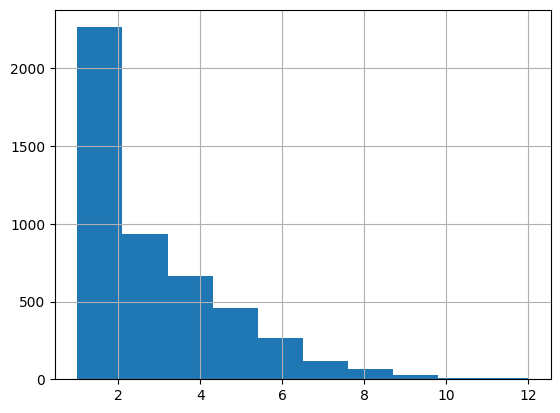

In [223]:
df['client_id'].value_counts().hist()